### This file attempts to make predictions on AI4I Predictive Maintenance Dataset (2020)
- Dataset gotten from kaggle: https://www.kaggle.com/datasets/stephanmatzka/predictive-maintenance-dataset-ai4i-2020
- This dataset is part of the following publication, please cite when using this dataset:\
S. Matzka, "Explainable Artificial Intelligence for Predictive Maintenance Applications," 2020 Third International \ Conference on Artificial Intelligence for Industries (AI4I), 2020, pp. 69-74, doi: 10.1109/AI4I49448.2020.00023.

- The image of the milling process is the work of Daniel Smyth @ Pexels: https://www.pexels.com/de-de/foto/  \ industrie-herstellung-maschine-werkzeug-10406128/

In [141]:
# import necessary modules
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import PowerTransformer
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import roc_auc_score, confusion_matrix, f1_score

In [2]:
# read in data
failure_df = pd.read_csv("ai4i2020.csv")
print(f"Data shape: {failure_df.shape}")
failure_df.head()

Data shape: (10000, 14)


,UDI,Product ID,Type,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
0,1,M14860,M,298.1,308.6,1551,42.8,0,0,0,0,0,0,0
1,2,L47181,L,298.2,308.7,1408,46.3,3,0,0,0,0,0,0
2,3,L47182,L,298.1,308.5,1498,49.4,5,0,0,0,0,0,0
3,4,L47183,L,298.2,308.6,1433,39.5,7,0,0,0,0,0,0
4,5,L47184,L,298.2,308.7,1408,40.0,9,0,0,0,0,0,0


### Explore data

In [3]:
failure_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   UDI                      10000 non-null  int64  
 1   Product ID               10000 non-null  object 
 2   Type                     10000 non-null  object 
 3   Air temperature [K]      10000 non-null  float64
 4   Process temperature [K]  10000 non-null  float64
 5   Rotational speed [rpm]   10000 non-null  int64  
 6   Torque [Nm]              10000 non-null  float64
 7   Tool wear [min]          10000 non-null  int64  
 8   Machine failure          10000 non-null  int64  
 9   TWF                      10000 non-null  int64  
 10  HDF                      10000 non-null  int64  
 11  PWF                      10000 non-null  int64  
 12  OSF                      10000 non-null  int64  
 13  RNF                      10000 non-null  int64  
dtypes: float64(3), int64(9)

- Looks like there are no mising values

In [4]:
# display simple satistics
failure_df.describe()

,UDI,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure,TWF,HDF,PWF,OSF,RNF
count,10000.00000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,5000.50000,300.004930,310.005560,1538.776100,39.986910,107.951000,0.033900,0.004600,0.011500,0.009500,0.009800,0.00190
std,2886.89568,2.000259,1.483734,179.284096,9.968934,63.654147,0.180981,0.067671,0.106625,0.097009,0.098514,0.04355
min,1.00000,295.300000,305.700000,1168.000000,3.800000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
25%,2500.75000,298.300000,308.800000,1423.000000,33.200000,53.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
50%,5000.50000,300.100000,310.100000,1503.000000,40.100000,108.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
75%,7500.25000,301.500000,311.100000,1612.000000,46.800000,162.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000
max,10000.00000,304.500000,313.800000,2886.000000,76.600000,253.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000


In [5]:
# check any duplicates
failure_df.duplicated().sum()

np.int64(0)

In [137]:
failure_df["Machine failure"].value_counts(normalize=True)

Machine failure
0    0.9661
1    0.0339
Name: proportion, dtype: float64

## Visualize Data

In [8]:
# I'll drop error modes and ID, keeping only sensor data and the Machine Failure feature.
training_df = failure_df.drop(columns=["UDI", "Product ID", "Type", "TWF", "HDF", "PWF", "OSF", "RNF"])
training_df.head()

,Air temperature [K],Process temperature [K],Rotational speed [rpm],Torque [Nm],Tool wear [min],Machine failure
0,298.1,308.6,1551,42.8,0,0
1,298.2,308.7,1408,46.3,3,0
2,298.1,308.5,1498,49.4,5,0
3,298.2,308.6,1433,39.5,7,0
4,298.2,308.7,1408,40.0,9,0


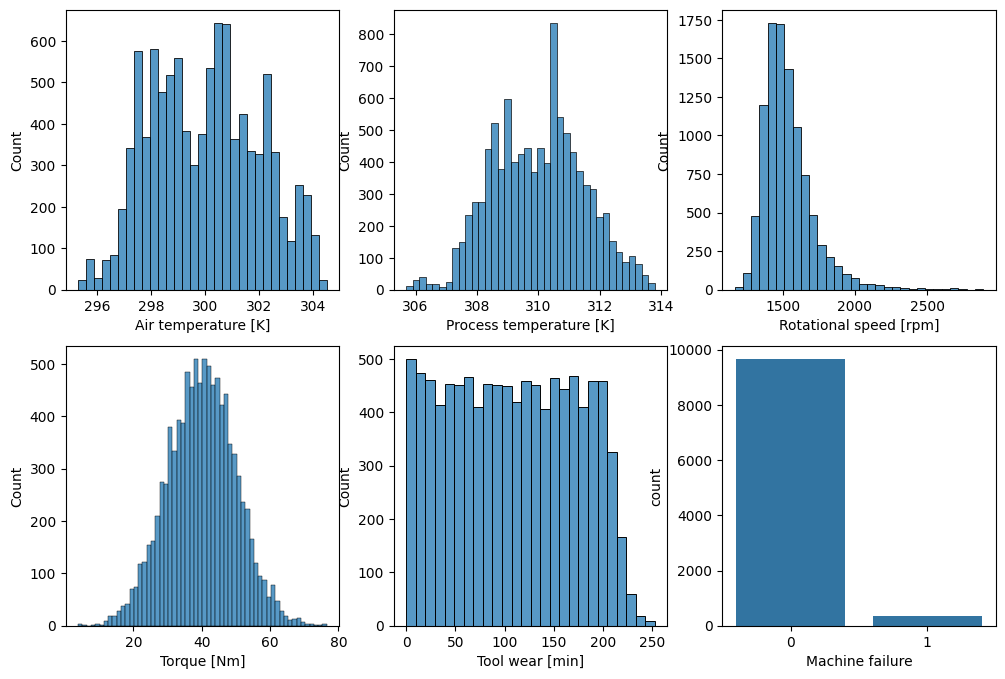

In [ ]:
# create a figure with 2 rows and 3 columns
figure, axes = plt.subplots(2, 3, figsize=(12, 8))
sns.histplot(data=training_df, x="Air temperature [K]", ax=axes[0,0])
sns.histplot(data=training_df, x="Process temperature [K]", ax=axes[0,1])
sns.histplot(data=training_df, x="Rotational speed [rpm]", bins=30, ax=axes[0,2])
sns.histplot(data=training_df, x="Torque [Nm]", ax=axes[1,0])
sns.histplot(data=training_df, x="Tool wear [min]", ax=axes[1,1])
sns.countplot(data=training_df, x="Machine failure", ax=axes[1,2])
plt.show()

### Comments
- Target feature is imbalanced. There are very few cases of failure.
- Most features look to have a normal distribution except Rotational speed and Tool wear
- Rotational speed looks left skewed.

### Data Transformation

In [27]:
# drop target feature
X = training_df.drop(columns="Machine failure")
y = training_df["Machine failure"]

# Normalize and standardize data using Power Transformer
failure_norm = PowerTransformer().fit_transform(X)
failure_norm.shape

(10000, 5)

In [30]:
# split into training and testing sets using stratified sampling
training_x, x_test, training_y, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# split data into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(training_x, training_y, stratify=training_y, test_size=0.1, random_state=42)
x_train.shape, y_train.shape

((7200, 5), (7200,))

## Build and Test model

### 1. Logistic Regression

In [92]:
# build and fit logistic regression model setting class weights as balanced
LR = LogisticRegression(C=0.1, solver="liblinear", class_weight="balanced", random_state=42)
LR.fit(x_train, y_train)

LogisticRegression(C=0.1, class_weight='balanced', random_state=42,
                   solver='liblinear')

In [93]:
# make predictions and visualize confusion matrix
ypred = LR.predict(x_val)
confusion_matrix(y_val, ypred)

array([[617, 156],
       [  3,  24]])

In [94]:
# score model using auc score
lr_roc =  roc_auc_score(y_val, ypred)
lr_f1 =  f1_score(y_val, ypred)

### 2. Decision Tree

In [60]:
# build and fit decision tree
tree = DecisionTreeClassifier(criterion="entropy", class_weight="balanced", max_depth=8, random_state=42)
tree.fit(x_train, y_train)

DecisionTreeClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, random_state=42)

In [61]:
# make predictions and visualize confusion matrix
ypred = tree.predict(x_val)
confusion_matrix(y_val, ypred)

array([[742,  31],
       [  4,  23]])

In [62]:
# score model using auc score
tree_roc =  roc_auc_score(y_val, ypred)
tree_f1 =  f1_score(y_val, ypred)

### 3. Random Forest

In [107]:
# build and fit random forest model
forest = RandomForestClassifier(n_estimators=5, criterion="entropy", class_weight="balanced", max_depth=8, random_state=42)
forest.fit(x_train, y_train)

RandomForestClassifier(class_weight='balanced', criterion='entropy',
                       max_depth=8, n_estimators=5, random_state=42)

In [108]:
# make predictions and visualize confusion matrix
ypred = forest.predict(x_val)
confusion_matrix(y_val, ypred)

array([[751,  22],
       [  6,  21]])

In [109]:
# score model using auc score
forest_roc =  roc_auc_score(y_val, ypred)
forest_f1 =  f1_score(y_val, ypred)

### 4. Gradient Boosting

In [169]:
# build and fit model
gb_model = GradientBoostingClassifier(max_depth=4, random_state=42)
gb_model.fit(x_train, y_train)

GradientBoostingClassifier(max_depth=4, random_state=42)

In [133]:
# make predictions and visualize confusion matrix
ypred = gb_model.predict(x_val)
confusion_matrix(y_val, ypred)

array([[768,   5],
       [  5,  22]])

In [134]:
# score model using auc score
gb_roc =  roc_auc_score(y_val, ypred)
gb_f1 =  f1_score(y_val, ypred)

In [135]:
# Display validation scores
scores = {"ROC_score": [lr_roc, tree_roc, forest_roc, gb_roc],
          "F1_score": [lr_f1, tree_f1, forest_f1, gb_f1]}
indices = ["Logistic Regression", "Decision Tree", "Random Forest", "Gradient Boosting"]
pd.DataFrame(scores, index=indices)

,ROC_score,F1_score
Logistic Regression,0.843539,0.231884
Decision Tree,0.905874,0.567901
Random Forest,0.874659,0.600000
Gradient Boosting,0.904173,0.814815


- Gradient Boosting model performs best with a high ROC score and F1 score as well.
- Using grid search cross-validation we could find the optimal parameters for boosting algorithm.

### GridSearch Cross Validation

In [142]:
gb_model = GradientBoostingClassifier(random_state=42)

In [153]:
# set tunning parameters
params = {

    "n_estimators":[50, 100, 150],
    "learning_rate": [0.1, 0.5],
    "criterion": ["friedman_mse", "squared_error"],
    "max_depth": [None, 4, 6],
}

# set crossvalidation type. 5 fold stratified cross validation
cv = StratifiedKFold(5)

# set scoring metrics used
scoring = { "roc_score": "roc_auc", "f1_score": "f1" }

grid_search = GridSearchCV(
    estimator=gb_model,
    param_grid=params,
    cv=cv,
    scoring=scoring,
    refit="f1_score"
)

# fit on all training data
grid_search.fit(training_x, training_y)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
             estimator=GradientBoostingClassifier(random_state=42),
             param_grid={'criterion': ['friedman_mse', 'squared_error'],
                         'learning_rate': [0.1, 0.5], 'max_depth': [None, 4, 6],
                         'n_estimators': [50, 100, 150]},
             refit='f1_score',
             scoring={'f1_score': 'f1', 'roc_score': 'roc_auc'})

In [158]:
# obtain and display results as a dataframe
results_df = pd.DataFrame(grid_search.cv_results_)
best_models = results_df.sort_values("rank_test_f1_score")
features = ["param_criterion", "param_max_depth", "param_n_estimators", "param_learning_rate", "mean_test_roc_score", "mean_test_f1_score", "rank_test_f1_score"]
best_models[features].head()

,param_criterion,param_max_depth,param_n_estimators,param_learning_rate,mean_test_roc_score,mean_test_f1_score,rank_test_f1_score
23,squared_error,4,150,0.1,0.966645,0.745750,1
5,friedman_mse,4,150,0.1,0.969619,0.736927,2
24,squared_error,6,50,0.1,0.968830,0.727849,3
4,friedman_mse,4,100,0.1,0.970310,0.726367,4
22,squared_error,4,100,0.1,0.969613,0.726367,4


### Make predictions with best model

In [166]:
# return the best model from grid search
best_model = grid_search.best_estimator_
ypred = best_model.predict(x_test)
# display confusion matrix
confusion_matrix(y_test, ypred)

array([[1924,    8],
       [  20,   48]])

In [167]:
print(f"roc score: {roc_auc_score(y_test, ypred):.2f}, f1 score: {f1_score(y_test, ypred):.2f}")

roc score: 0.85, f1 score: 0.77
